In [18]:
import netCDF4 as nc 
# miscellaneous operating system interfaces
import os

# visualizes the data
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

#processes the data
import numpy as np 
import pandas as pd

# helps visualize the data
import cartopy.crs as ccrs 
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.feature import BORDERS, COASTLINE


from matplotlib.colors import TwoSlopeNorm

import geopandas as gpd
from shapely.geometry import Point

from sklearn.decomposition import PCA

In [2]:
# LOAD DATA
file_path = '../Data/GRCTellus.JPL.200204_202411.GLO.RL06.3M.MSCNv04CRI.nc'

# Check if the file exists
if os.path.exists(file_path):
    mascons = nc.Dataset(file_path)
else:
    raise FileNotFoundError(f"File not found: {file_path}")

In [3]:
# try to reformat time into months
from datetime import datetime, timedelta

# Extract necessary variables
time_data = mascons.variables['time'][:]  # Time in days since 2002-01-01T00:00:00Z
lwe_thickness = mascons.variables['lwe_thickness'][:]  # Shape (239, 360, 720)
only_land_mask = np.array(mascons["lwe_thickness"]) * np.array(mascons["land_mask"]) # Shape (360, 720)
print(only_land_mask.shape)

# Step 1: Convert time to datetime
start_date = datetime(2002, 1, 1)
time_dates = np.array([start_date + timedelta(days=int(t)) for t in time_data])

# Step 2: Create a pandas DataFrame for grouping
time_df = pd.DataFrame({'time': time_dates})
time_df['year_month'] = time_df['time'].dt.to_period('M')  # Convert to 'YYYY-MM' format for grouping

(239, 360, 720)


In [4]:
def plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index=None):
    """
    Plots the LWE thickness for a specific region defined by center latitude, center longitude,
    width, and height in degrees, applying a landmask.

    Parameters:
        center_lat (float): Center latitude of the region.
        center_lon (float): Center longitude of the region.
        width (float): Width of the region in degrees.
        height (float): Height of the region in degrees.
        time_index (int, optional): Index of the time step to plot. If None, defaults to the global variable i.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    # Adjust center_lon to match the dataset's range (0 to 360)
    if center_lon < 0:
        center_lon += 360

    # Calculate the bounds of the region
    lat_min = max(center_lat - height / 2, 45) #45 N as a treshold to get the right frame for canada
    lat_max = min(center_lat + height / 2, 70) #70 N as a threshold to get the right frame to not get nunavut
    lon_min = center_lon - width / 2
    lon_max = center_lon + width / 2

    # Filter the latitude and longitude indices
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

    # Check if indices are valid
    if len(lat_indices) == 0 or len(lon_indices) == 0:
        print("No data available for the specified region.")
        return

    # Extract the subset of data
    subset_lat = lat[lat_indices]
    subset_lon = lon[lon_indices]
    time_idx = time_index if time_index is not None else i
    subset_lwe_thickness = only_land_mask[time_idx, lat_indices[:, None], lon_indices] #changed this to only_land_mask could be also lwe_thickness

    # Check if subset_lwe_thickness is valid
    if subset_lwe_thickness.size == 0:
        print("No LWE thickness data available for the specified region.")
        return

    # Create a figure and axis with a Cartopy projection
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Define a normalization that centers the colorbar at 0
    data_min = subset_lwe_thickness.min()
    data_max = subset_lwe_thickness.max()
    data_min=-data_max
    if data_min < 0 and data_max > 0:
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0, vmax=data_max)
    else:
        norm = plt.Normalize(vmin=data_min, vmax=data_max)

    # Plot the lwe_thickness for the specified time step with the defined normalization
    lwe_plot = ax.pcolormesh(subset_lon, subset_lat, subset_lwe_thickness, 
                             cmap='seismic', norm=norm, transform=ccrs.PlateCarree())

    # Add coastlines, borders, and gridlines
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.gridlines(draw_labels=True)

    # Add a colorbar
    cbar = plt.colorbar(lwe_plot, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Liquid Water Equivalent Thickness')

    # Set the colorbar ticks and range
    #cbar.set_ticks(np.linspace(data_min, data_max, num=5))  # 5 evenly spaced ticks
    #cbar.ax.tick_params(labelsize=10)  # Adjust tick label size

    # Set the title
    ax.set_title(f'LWE Thickness for Month {time_idx + 1} in Region ({center_lat}, {center_lon})')
    
    return fig, data_min, data_max



data_min -237.644336204148
data_max 237.644336204148


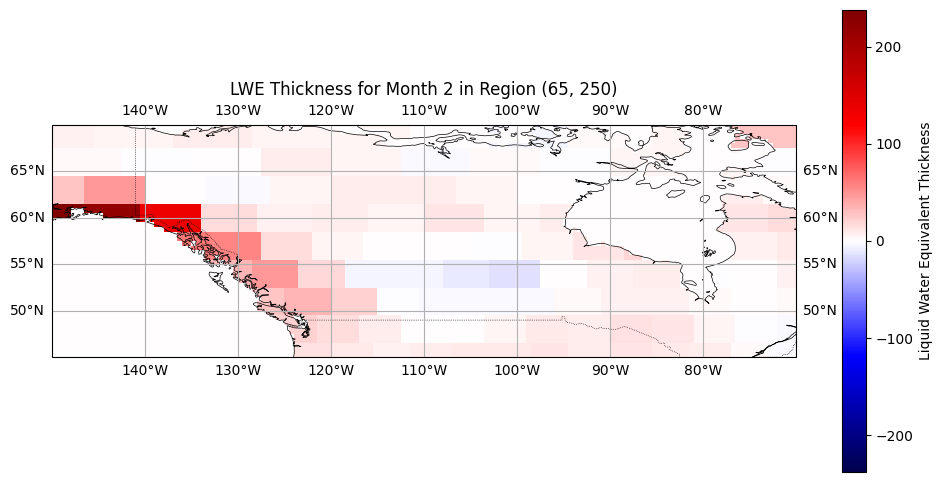

In [5]:
# Plotting the LWE thickness with landmask for canada
# Set the right rectangle parameters for canada
center_lat = 65
center_lon = -110
width = 80
height = 40
time_index = 1

lat = mascons.variables['lat'][:]
lon = mascons.variables['lon'][:]
lwe_thickness = mascons.variables['lwe_thickness'][:]

fig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)
print("data_min", data_min)
print("data_max", data_max)
# Show the plot
plt.show()

#### Starting with the EOF of Canada

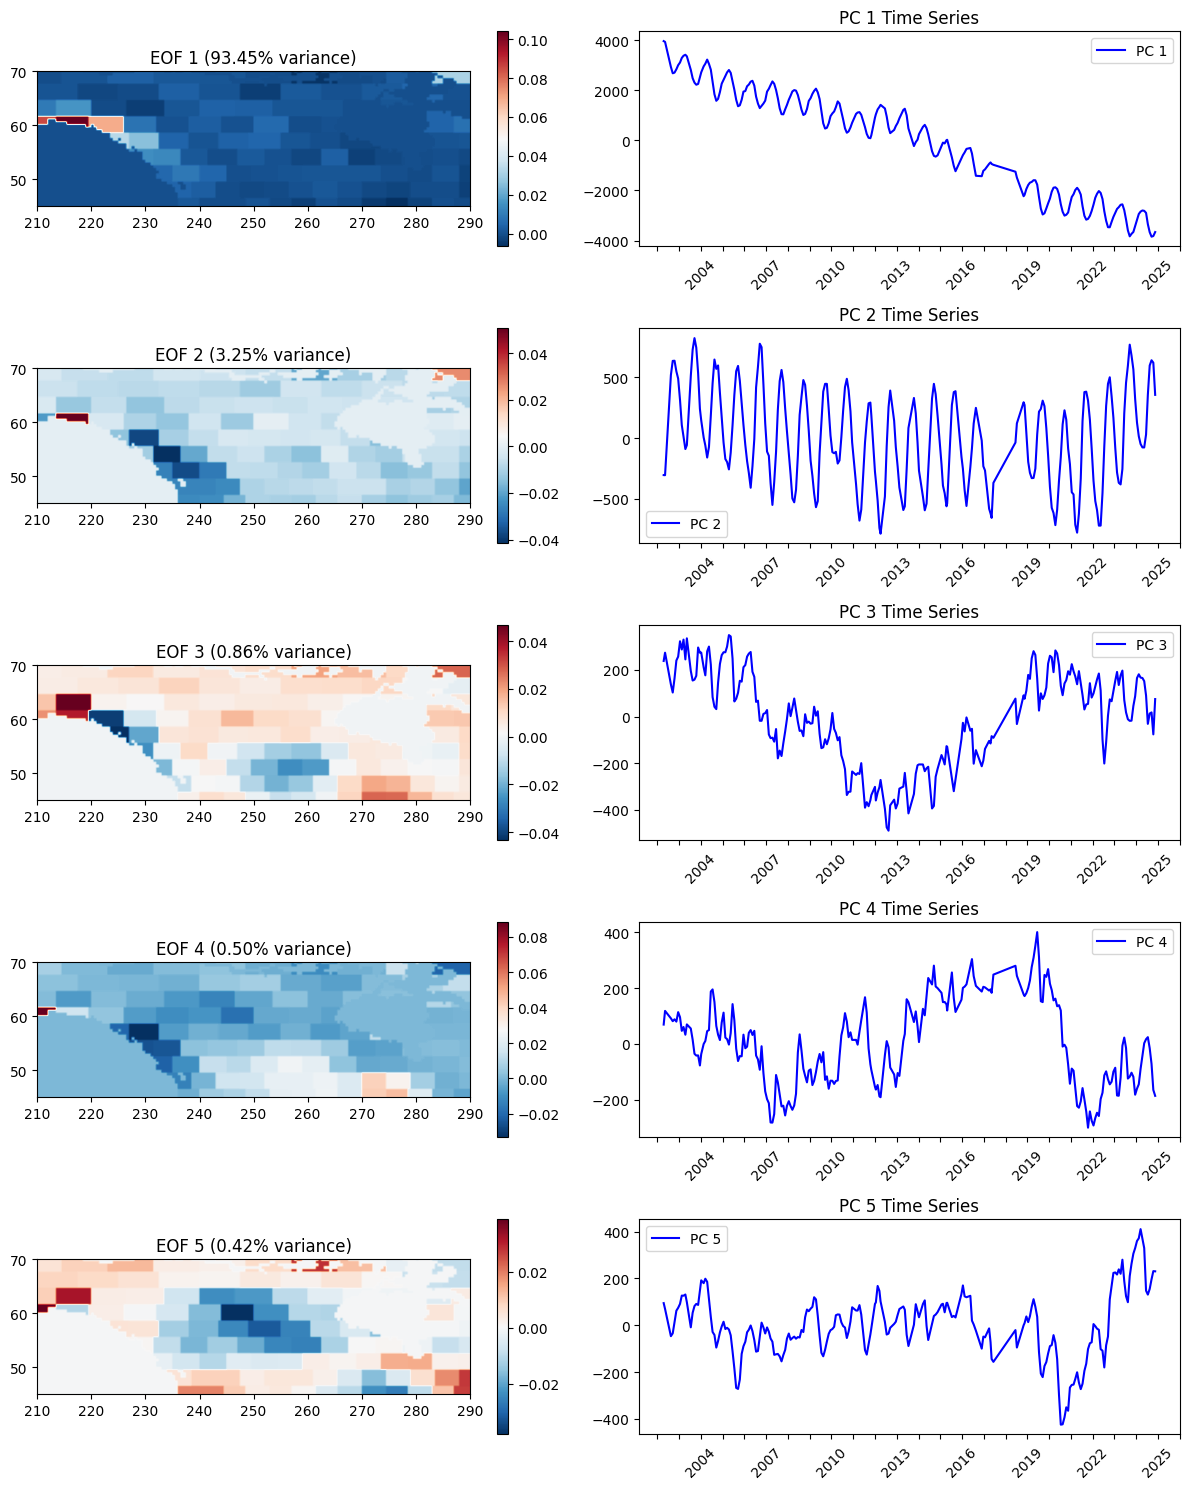

In [19]:
# Define the region of interest
center_lat = 65
center_lon = -110
width = 80
height = 40

# Adjust center_lon to match the dataset's range (0 to 360)
if center_lon < 0:
    center_lon += 360

# Calculate the bounds of the region
lat_min = max(center_lat - height / 2, 45)  # Ensure latitude is not below 45°N
lat_max = min(center_lat + height / 2, 70)  # Ensure latitude is not above 70°N
lon_min = center_lon - width / 2
lon_max = center_lon + width / 2

# Filter the latitude and longitude indices
lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

# Check if indices are valid
if len(lat_indices) == 0 or len(lon_indices) == 0:
    raise ValueError("No data available for the specified region.")

# Extract the subset of data
subset_lat = lat[lat_indices]
subset_lon = lon[lon_indices]
subset_data = only_land_mask[:, lat_indices[:, None], lon_indices]  # Shape: (time, lat, lon)

# Flatten spatial dimensions for PCA
num_time_steps = subset_data.shape[0]
num_lat = len(lat_indices)
num_lon = len(lon_indices)
reshape_data = subset_data.reshape(num_time_steps, num_lat * num_lon)

# Remove time mean to compute anomalies (centering the data)
column_time_mean = np.mean(reshape_data, axis=0, keepdims=True)
data_centered = reshape_data - column_time_mean

# Perform PCA
pca = PCA(n_components=5)
pca.fit(data_centered)
transformed_data = pca.transform(data_centered)
explained_variance = pca.explained_variance_ratio_

# Visualize the EOFs and their time series
fig, axes = plt.subplots(5, 2, figsize=(12, 15))  # Adjust as needed
for i in range(5):  # Plot first 5 EOFs and their time series
    # EOF spatial pattern
    eof_pattern = pca.components_[i].reshape(num_lat, num_lon)
    im = axes[i, 0].imshow(eof_pattern, cmap='RdBu_r', origin='lower',
                           extent=[lon_min, lon_max, lat_min, lat_max])
    axes[i, 0].set_title(f'EOF {i+1} ({explained_variance[i]*100:.2f}% variance)')
    fig.colorbar(im, ax=axes[i, 0])

    # Principal component time series
    axes[i, 1].plot(time_dates, transformed_data[:, i], label=f'PC {i+1}', color='b')  # Use time_dates for x-axis
    axes[i, 1].set_title(f'PC {i+1} Time Series')
    axes[i, 1].legend()

    # Set ticks every year
    axes[i, 1].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year

    # Format labels to show the year only every 3 years
    def custom_year_formatter(x, pos):
        year = mdates.num2date(x).year
        return str(year) if year % 3 == 0 else ''  # Show year only if divisible by 3

    axes[i, 1].xaxis.set_major_formatter(FuncFormatter(custom_year_formatter))

    # Rotate the tick labels for better readability
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

   PRUID        DGUID                                             PRNAME  \
0     10  2021A000210  Newfoundland and Labrador / Terre-Neuve-et-Lab...   
1     11  2021A000211       Prince Edward Island / Île-du-Prince-Édouard   
2     12  2021A000212                      Nova Scotia / Nouvelle-Écosse   
3     13  2021A000213                  New Brunswick / Nouveau-Brunswick   
4     24  2021A000224                                    Quebec / Québec   
5     35  2021A000235                                            Ontario   
6     46  2021A000246                                           Manitoba   
7     47  2021A000247                                       Saskatchewan   
8     48  2021A000248                                            Alberta   
9     59  2021A000259            British Columbia / Colombie-Britannique   
10    60  2021A000260                                              Yukon   
11    61  2021A000261  Northwest Territories / Territoires du Nord-Ouest   

           

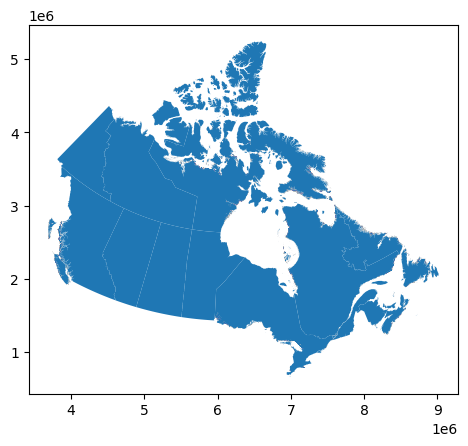

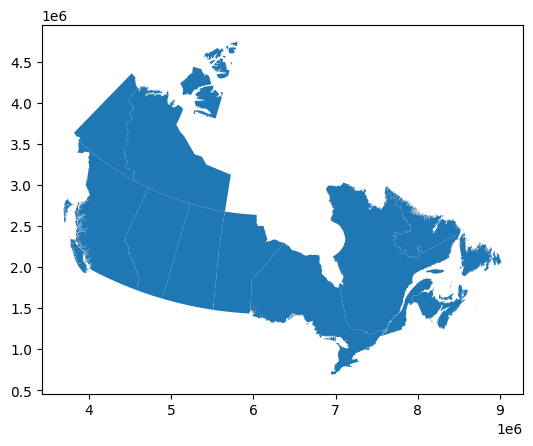

In [6]:
from shapely.geometry import Point
canada_shape = gpd.read_file('../Data/lpr_000b21a_e/lpr_000b21a_e.shp')
canada_shape.plot()
canada_shape

# Filter out the PRNAME "Nunavut"
canada_shape_filtered = canada_shape[canada_shape['PRNAME'] != 'Nunavut']

# Plot the filtered shapefile
canada_shape_filtered.plot()
print(canada_shape_filtered)

In [7]:
print(canada_shape_filtered)

   PRUID        DGUID                                             PRNAME  \
0     10  2021A000210  Newfoundland and Labrador / Terre-Neuve-et-Lab...   
1     11  2021A000211       Prince Edward Island / Île-du-Prince-Édouard   
2     12  2021A000212                      Nova Scotia / Nouvelle-Écosse   
3     13  2021A000213                  New Brunswick / Nouveau-Brunswick   
4     24  2021A000224                                    Quebec / Québec   
5     35  2021A000235                                            Ontario   
6     46  2021A000246                                           Manitoba   
7     47  2021A000247                                       Saskatchewan   
8     48  2021A000248                                            Alberta   
9     59  2021A000259            British Columbia / Colombie-Britannique   
10    60  2021A000260                                              Yukon   
11    61  2021A000261  Northwest Territories / Territoires du Nord-Ouest   

           

Note: Provinces that we should filter in: 
- British Colombia
- Alberta
- Manitoba
- Ontario
- Saskatchewan
- Quebec

all except Nunavut

In [13]:
print(canada_geometry.bounds)
'''
# Create a mask for the region defined by the filtered shapefile
points = np.array([lon_grid.flatten(), lat_grid.flatten()]).T
canada_mask = np.array([canada_geometry.contains(Point(p)) for p in points]).reshape(lon_grid.shape)

# Apply the mask to the lwe_thickness data
masked_lwe_thickness = np.ma.masked_where(~canada_mask, lwe_thickness[time_index])

# Plot the LWE thickness for the specified region
fig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)
print("data_min", data_min)
print("data_max", data_max)
# Show the plot
plt.show()'''

(3689321.4628571793, 659305.0028571747, 9015750.722857185, 4748587.44285718)


'\n# Create a mask for the region defined by the filtered shapefile\npoints = np.array([lon_grid.flatten(), lat_grid.flatten()]).T\ncanada_mask = np.array([canada_geometry.contains(Point(p)) for p in points]).reshape(lon_grid.shape)\n\n# Apply the mask to the lwe_thickness data\nmasked_lwe_thickness = np.ma.masked_where(~canada_mask, lwe_thickness[time_index])\n\n# Plot the LWE thickness for the specified region\nfig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)\nprint("data_min", data_min)\nprint("data_max", data_max)\n# Show the plot\nplt.show()'